# Compare Original vs Preprocessed Images

This notebook compares original MRI images with their pre-processed versions from the test set.

In [16]:
# Import libraries
import os
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
# Setup paths
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
img_data_dir = os.path.join(repo_root, "data", "brain-cancer-mri-dataset", "Brain_Cancer raw MRI data", "Brain_Cancer")
output_dir = os.path.join(repo_root, "data", "brain-cancer-mri-dataset", "preprocessed_samples")
os.makedirs(output_dir, exist_ok=True)

In [18]:
# Define preprocessing transforms (matching training notebook)
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Grayscale(num_output_channels=3),     # ensure 3 channels if images are grayscale
    v2.ToImage(),                            # PIL -> Tensor
    v2.ToDtype(torch.float32, scale=True),   # [0,255] -> [0,1] float
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

In [19]:
# Load dataset and create test split
full_dataset = datasets.ImageFolder(root=img_data_dir)
targets = np.array([y for _, y in full_dataset.samples])
indices = np.arange(len(full_dataset))

# Split (matching training notebook: 70/15/15)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
_, test_idx = next(sss.split(indices, targets))

print(f"Classes: {full_dataset.classes}")
print(f"Test set size: {len(test_idx)}")

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Test set size: 909


In [20]:
# Denormalization function
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

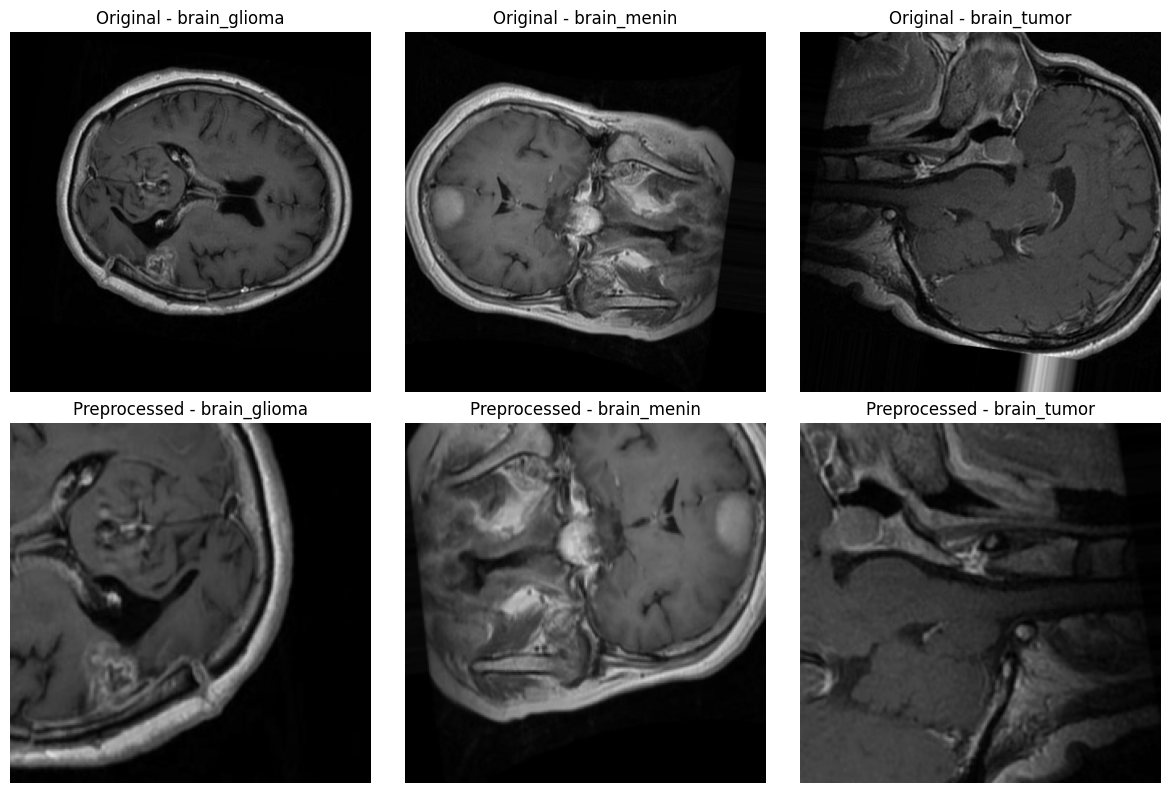


Saved comparison figure to: c:\Users\Luke\OneDrive - Heriot-Watt University\Desktop\DM_ML\CodeRepo\group-coursework-swans\data\brain-cancer-mri-dataset\preprocessed_samples


In [ ]:
# Create and save individual comparison figures (original & preprocessed per class)
original_ds = datasets.ImageFolder(root=img_data_dir)
preprocessed_ds = datasets.ImageFolder(root=img_data_dir, transform=transforms)

# Find one sample per class from test set
test_targets = targets[test_idx]
samples_per_class = {}
for idx, sample_idx in enumerate(test_idx):
    label = test_targets[idx]
    if label not in samples_per_class:
        samples_per_class[label] = sample_idx
    if len(samples_per_class) == 3:
        break

class_names = full_dataset.classes

for class_idx in range(3):
    sample_idx = samples_per_class[class_idx]

    # Original image
    orig_img, _ = original_ds[sample_idx]
    orig_img_array = np.array(orig_img)
    plt.figure(figsize=(4, 4))
    plt.imshow(orig_img_array, cmap='gray' if len(orig_img_array.shape) == 2 else None)
    plt.axis('off')
    orig_filename = f"original_{class_names[class_idx]}.png"
    plt.savefig(os.path.join(output_dir, orig_filename), dpi=150, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Preprocessed image (denormalized)
    prep_img, _ = preprocessed_ds[sample_idx]
    prep_img_denorm = denormalize(prep_img)
    prep_img_array = prep_img_denorm.permute(1, 2, 0).numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(prep_img_array)
    plt.axis('off')
    prep_filename = f"preprocessed_{class_names[class_idx]}.png"
    plt.savefig(os.path.join(output_dir, prep_filename), dpi=150, bbox_inches='tight', pad_inches=0)
    plt.close()

print("Saved individual original and preprocessed images to:", output_dir)